# Submanifold Closure


## Setup

In [3]:
%load_ext autoreload
import jax.numpy as jnp
from jaxtyping import Array
import matplotlib.pyplot as plt
import dynamiqs as dq
import strawberryfields as sf
import os
from jaxpulse.controllers import ControlVector, SinusoidalControl, ConstantControl, FrequencyControl, GaussianControl
from jaxpulse.optimizers import ClosedQuantumSystem, OptimalController
from jaxpulse.utils import heaviside, rhodot_H
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='.90'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Drift

In [4]:
alpha = .1
beta = .2
delta = .5+.4j
gamma = .1
epsilon = 1.5 + 2j
def c(v):
    return jnp.conj(v)
H_0 = jnp.array(
    [
        [1.0,       alpha,      beta,       0.0,        0.0],
        [c(alpha),  2,          delta,      0.0,        0.0],
        [c(beta),   c(delta),   3,          gamma,      0.0],
        [0.0,       0.0,        c(gamma),   4,          epsilon],
        [0.0,       0.0,        0.0,        c(epsilon), 5]
    ]
)

### Controls

In [5]:
H_1 = jnp.array(
    [
        [0.0,  0.0,  0.0,  0.0,  0.0],
        [0.0,  0.0,  1.0,  0.0,  0.0],
        [0.0,  1.0,  0.0,  0.0,  0.0],
        [0.0,  0.0,  0.0,  0.0,  0.0],
        [0.0,  0.0,  0.0,  0.0,  0.0]
    ]
)
H_2 = jnp.array(
    [
        [0.0,  1.0,  0.0,  0.0,  0.0],
        [1.0,  0.0,  0.0,  0.0,  0.0],
        [0.0,  0.0,  0.0,  0.0,  0.0],
        [0.0,  0.0,  0.0,  0.0,  0.0],
        [0.0,  0.0,  0.0,  0.0,  0.0]
    ]
)
H_3 = jnp.array(
    [
        [0.0,  0.0,  0.0,  0.0,  0.0],
        [0.0,  0.0,  0.0,  0.0,  0.0],
        [0.0,  0.0,  0.0,  1.0,  0.0],
        [0.0,  0.0,  1.0,  0.0,  0.0],
        [0.0,  0.0,  0.0,  0.0,  0.0]
    ]
)
H_M = [H_1, H_2, H_3]
ppc = [3,3,3] # pulse per control
u_M = ControlVector(
    [
        GaussianControl(
            amp=1.0*jnp.ones((ppc[0],)),
            mean=jnp.linspace(3,9,ppc[0]),
            sigma=jnp.ones((ppc[0],))
        ),
        GaussianControl(
            amp=1.0*jnp.ones((ppc[1],)),
            mean=jnp.linspace(2,10,ppc[1]),
            sigma=1.0*jnp.ones((ppc[1],))
        ),
        GaussianControl(
            amp=1.0*jnp.ones((ppc[2],)),
            mean=jnp.linspace(2,12,ppc[2]),
            sigma=1.0*jnp.ones((ppc[2],))
        )
    ]
)

In [6]:
closure_sys = ClosedQuantumSystem(
    H_0=H_0,
    H_M=H_M
)
psi0 = dq.fock(5, 0)
duration=15

## State Exclusion
go to 2, avoid 3,4

In [7]:
# project into 3rd
proj = dq.fock_dm(5,2)
def y_final(y: Array) -> float:
    return 1000*(1 - dq.expect(proj, y))

# don't go above 3
exclude_upper = dq.fock_dm(5,3) #+ dq.fock_dm(5,4)
def y_statewise(y: Array, u: Array, t: float) -> float:
    return dq.expect(exclude_upper, y) 

In [8]:
controller = OptimalController(
    system=closure_sys,
    controls=u_M,
    y0=psi0,
    duration=duration,
    y_final=y_final,
    y_statewise=y_statewise
)
exp_ops = [dq.number(5),proj]
exp_names = [r"$\langle n \rangle$", r"$\langle 2 \rangle$"]

### Pre-Train

/home/cjblake/miniconda3/envs/jiang/lib/python3.12/site-packages/equinox/_jit.py:51: UserWarning: Complex dtype support is work in progress, please read https://github.com/patrick-kidger/diffrax/pull/197 and proceed carefully.
/tmp/ipykernel_79187/3636940499.py:6: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


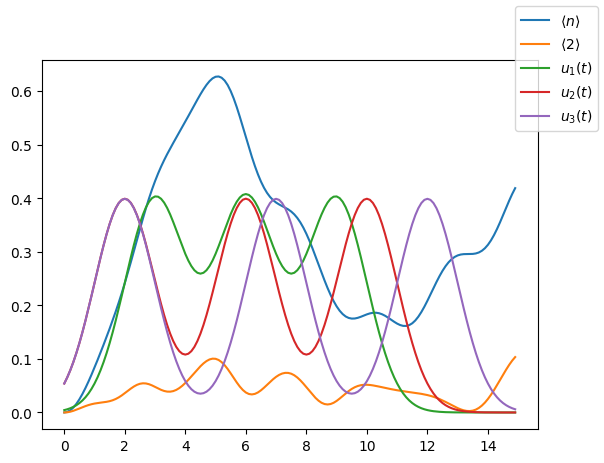

In [9]:
fig_pre, ax_pre = plt.subplots()
controller.plot(ax_pre,
                exp_ops=exp_ops,
                exp_names=exp_names)
fig_pre.legend()
fig_pre.show()

### Train

In [10]:
opt_controller = controller.optimize(
    N_steps=60,
    learning_rate=.1,
    verbosity=1)

/home/cjblake/miniconda3/envs/jiang/lib/python3.12/site-packages/equinox/_jit.py:51: UserWarning: Complex dtype support is work in progress, please read https://github.com/patrick-kidger/diffrax/pull/197 and proceed carefully.


Step: 0 Loss: 898.7310180664062
Step: 1 Loss: 742.378662109375
Step: 2 Loss: 560.052978515625
Step: 3 Loss: 370.15802001953125
Step: 4 Loss: 240.86300659179688
Step: 5 Loss: 146.10989379882812
Step: 6 Loss: 56.86347961425781
Step: 7 Loss: 61.900169372558594
Step: 8 Loss: 105.47737884521484
Step: 9 Loss: 63.951908111572266
Step: 10 Loss: 14.279641151428223
Step: 11 Loss: 9.876124382019043
Step: 12 Loss: 10.12311840057373
Step: 13 Loss: 9.53012752532959
Step: 14 Loss: 9.766767501831055
Step: 15 Loss: 25.370162963867188
Step: 16 Loss: 34.50824737548828
Step: 17 Loss: 17.19295883178711
Step: 18 Loss: 8.223649978637695
Step: 19 Loss: 6.111362934112549
Step: 20 Loss: 5.727139472961426
Step: 21 Loss: 5.138238906860352
Step: 22 Loss: 4.689647197723389
Step: 23 Loss: 4.390147686004639
Step: 24 Loss: 4.179327011108398
Step: 25 Loss: 4.075471878051758
Step: 26 Loss: 4.0391387939453125
Step: 27 Loss: 3.991410255432129
Step: 28 Loss: 3.928506851196289
Step: 29 Loss: 3.854444980621338
Step: 30 Loss:

/home/cjblake/miniconda3/envs/jiang/lib/python3.12/site-packages/equinox/_jit.py:51: UserWarning: Complex dtype support is work in progress, please read https://github.com/patrick-kidger/diffrax/pull/197 and proceed carefully.
/tmp/ipykernel_79187/2321787608.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


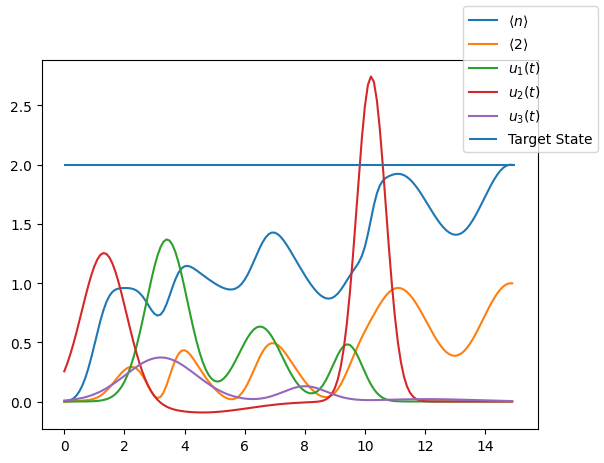

In [11]:
fig_post, ax_post = plt.subplots()
opt_controller.plot(ax_post,
                exp_ops=exp_ops,
                exp_names=exp_names)
ax_post.hlines(y=[2.0],xmin=0,xmax=duration,label="Target State")
fig_post.legend()
fig_post.show()

## Submanfold Stabilization (on $\rho$)
Go to 3, stay in 2,3

In [12]:
# project into 3rd
proj3 = dq.fock_dm(5,2)
def hit3(y: Array) -> float:
    return 1000*(1 - dq.expect(proj3, y))

# don't leave 2,3
def heaviside(t: float):
    return 1.0*(t > 0)
hold23 = dq.fock_dm(5,1) + dq.fock_dm(5,2)
def stay23(y: Array, u: Array, t: float) -> float:
    return heaviside(t-5)*(1 - dq.expect(hold23, y))

In [13]:
manifold_controller = OptimalController(
    system=closure_sys,
    controls=u_M,
    y0=psi0,
    duration=duration,
    y_final=hit3,
    y_statewise=stay23
)
m_exp_ops = [dq.number(5),proj3, hold23]
m_exp_names = [r"$\langle n \rangle$", r"$\langle 2 \rangle$", r"$\langle 2, 3 \rangle$"]

### Pre-Train

/home/cjblake/miniconda3/envs/jiang/lib/python3.12/site-packages/equinox/_jit.py:51: UserWarning: Complex dtype support is work in progress, please read https://github.com/patrick-kidger/diffrax/pull/197 and proceed carefully.
/tmp/ipykernel_79187/1240978354.py:6: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


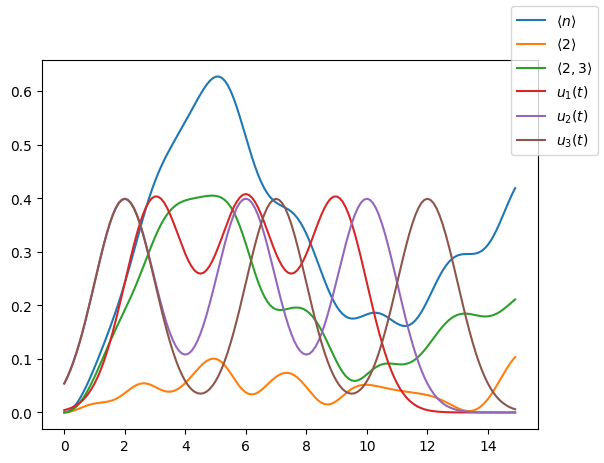

In [14]:
fig_pre, ax_pre = plt.subplots()
manifold_controller.plot(ax_pre,
                exp_ops=m_exp_ops,
                exp_names=m_exp_names)
fig_pre.legend()
fig_pre.show()

### Train

In [15]:
opt_manifold_controller = manifold_controller.optimize(
    N_steps=80,
    learning_rate=.1,
    verbosity=1
)

/home/cjblake/miniconda3/envs/jiang/lib/python3.12/site-packages/equinox/_jit.py:51: UserWarning: Complex dtype support is work in progress, please read https://github.com/patrick-kidger/diffrax/pull/197 and proceed carefully.


Step: 0 Loss: 978.4730834960938
Step: 1 Loss: 773.9912109375
Step: 2 Loss: 567.165283203125
Step: 3 Loss: 386.421142578125
Step: 4 Loss: 250.30479431152344
Step: 5 Loss: 172.6168975830078
Step: 6 Loss: 64.42263793945312
Step: 7 Loss: 155.53204345703125
Step: 8 Loss: 82.86941528320312
Step: 9 Loss: 40.084014892578125
Step: 10 Loss: 32.18384552001953
Step: 11 Loss: 28.354427337646484
Step: 12 Loss: 23.946971893310547
Step: 13 Loss: 20.6635799407959
Step: 14 Loss: 19.32695770263672
Step: 15 Loss: 19.239543914794922
Step: 16 Loss: 21.97379493713379
Step: 17 Loss: 64.11485290527344
Step: 18 Loss: 48.651893615722656
Step: 19 Loss: 36.22310256958008
Step: 20 Loss: 23.768308639526367
Step: 21 Loss: 17.10325050354004
Step: 22 Loss: 17.176570892333984
Step: 23 Loss: 17.92481231689453
Step: 24 Loss: 17.156463623046875
Step: 25 Loss: 16.05944061279297
Step: 26 Loss: 15.45596694946289
Step: 27 Loss: 15.193937301635742
Step: 28 Loss: 14.97272777557373
Step: 29 Loss: 14.704570770263672
Step: 30 Loss:

/home/cjblake/miniconda3/envs/jiang/lib/python3.12/site-packages/equinox/_jit.py:51: UserWarning: Complex dtype support is work in progress, please read https://github.com/patrick-kidger/diffrax/pull/197 and proceed carefully.
/tmp/ipykernel_79187/3566152222.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


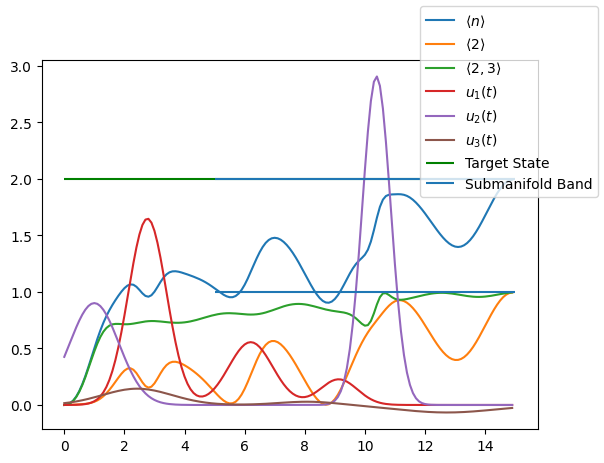

In [16]:
fig_post, ax_post = plt.subplots()
opt_manifold_controller.plot(ax_post,
                exp_ops=m_exp_ops,
                exp_names=m_exp_names)
ax_post.hlines(y=[2.0],xmin=0,xmax=duration,label="Target State",color='green')
ax_post.hlines(y=[1.0,2.0],xmin=5,xmax=duration,label="Submanifold Band")
fig_post.legend()
fig_post.show()

### Submanifold Stabilization (on $\dot{\rho}$)

In [17]:
# project into 2 to hit at end
proj3 = dq.fock_dm(5,2)
def hit3(y: Array) -> float:
    return 1000*(1 - dq.expect(proj3, y))

U = jnp.array(
    [
        [0.0, 0.0],
        [1.0, 0.0],
        [0.0, 1.0],
        [0.0, 0.0],
        [0.0, 0.0]
    ], dtype=complex
)
U_dag = dq.dag(U)

# don't leave 2,3

def her0_proj(sigmadot: Array): 
    return (
        dq.sigmax() * dq.trace(dq.sigmax() @ sigmadot) + 
        dq.sigmay() * dq.trace(dq.sigmay() @ sigmadot) + 
        dq.sigmaz() * dq.trace(dq.sigmaz() @ sigmadot)    
    )

hold23 = U @ U_dag
def stay23(y: Array, u: Array, t: float) -> float:
    H_tot = H_0
    for u_m, H_m in zip(u, H_M):
        H_tot = H_tot + H_m*u_m
    rhodot = rhodot_H(H_tot,y)
    sigmadot_tilde = U_dag @ rhodot @ U



    return heaviside(t-5)*norm